In [6]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Hyperparameters
cuda = True
epochs = 10
log_interval = 400
batchSize = 16

hidden_layer_size = 20

lr = 0.001

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        activation_1 = F.relu(self.fc1(x))
        x = self.fc2(activation_1)
        return x, activation_1
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc1): Linear (3072 -> 20)
  (fc2): Linear (20 -> 10)
)


In [14]:
class ActivationFollower():
    
    train_activations = 0
    test_activations = 0
    
    def __init__(self):
        self.train_activations = 0
        self.test_activations = 0
    
    def reset(self):
        train_activations = 0
        test_activations = 0
    
    def train_add(self, x):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
        else:
            self.train_activations = x
    
    def test_add(self, x):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
        else:
            self.test_activations = x
        
    def print_metrics(self):
        plt.figure(figsize=(20,10))
        bins = np.logspace(-8, 2, 11)
        plt.hist(np.where(self.train_activations == 0., 1, 0).mean(0))
        plt.show()
        for i in range(self.train_activations.shape[1]):
            plt.hist(self.train_activations.transpose()[i], log=True, bins=bins)
        plt.title('Histogram of activation values')
        plt.gca().set_xscale("log")
        # plt.xlim(0.01, 20)
        plt.show()
        

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [16]:
if cuda:
    model.cuda()
    criterion.cuda()

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations.cpu().data.numpy())
    for batch_idx, (data, target) in enumerate(testloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.test_add(activations.cpu().data.numpy())
        
    metrics.print_metrics()
    return metrics

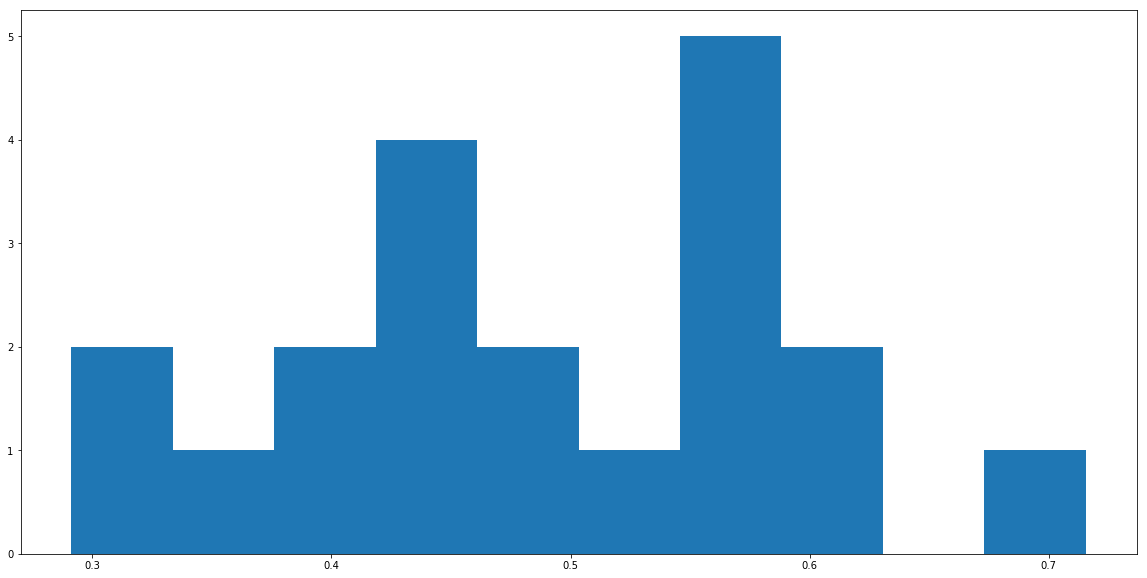

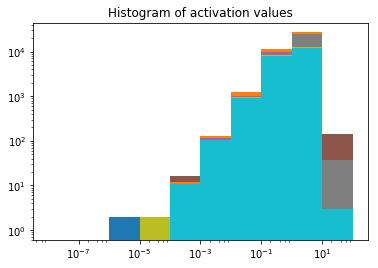

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.383096
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.688735
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.418925
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.475759
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.365377
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.981300
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.508128
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.954754

Test set: Average loss: 1.5578, Accuracy: 4494/10000 (45%)



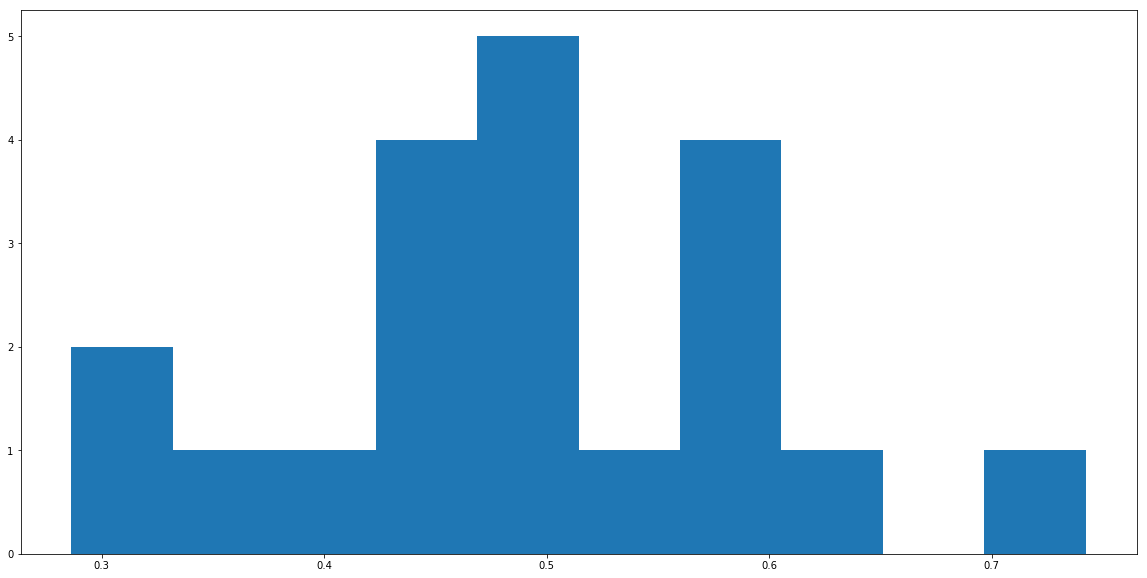

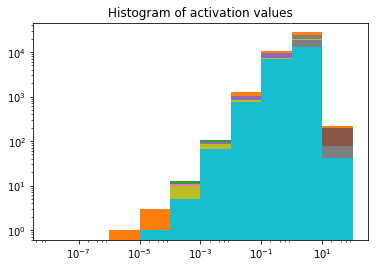

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.610329
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.964790
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.728951
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.263856
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.423537
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.833166
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.155859
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.712886

Test set: Average loss: 1.5403, Accuracy: 4569/10000 (46%)



In [ ]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()